In [2]:
%matplotlib inline

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from helpers import load_cascades, cascade_source
from sample_pool import TreeSamplePool
from tree_stat import TreeBasedStatistics
from graph_helpers import load_graph_by_name, k_hop_neighbors
from inference import infection_probability

from joblib import Parallel, delayed
from graph_tool.centrality import pagerank
from tqdm import tqdm
from sklearn.metrics import average_precision_score
from collections import defaultdict
from random_steiner_tree.util import from_gt



In [17]:
graph_name = 'grqc'
g = load_graph_by_name(graph_name)

In [18]:
n_samples= 250
sampling_method = 'loop_erased'


In [19]:
def pagerank_scores(g, obs):
    pers = g.new_vertex_property('float')
    for o in obs:
        pers[o] = 1 / len(obs)
    rank = pagerank(g, pers=pers)

    for o in obs:
        rank[o] = 0  # cannot select obs nodes
    p = rank.a / rank.a.sum()    
    return p

In [20]:
def build_cascade_source_sampler(g, obs, c, *args):
    def aux():
        return cascade_source(c)
    return aux

def build_root_sampler_by_pagerank_score(g, obs, c, p):
    def aux():
        return np.random.choice(np.arange(g.num_vertices()), size=1, p=p)[0]
    return aux

def build_earlier_root_sampler(g, obs, c, *args):
    def f():
        return min(obs, key=lambda o: c[o])
    return f

def build_early_nbrs_sampler(g, obs, c, *args, k=1):
    earliest_node = min(obs, key=lambda o: c[o])
    nbrs = list(k_hop_neighbors(earliest_node, g, k=k)) + [earliest_node]

    def f():
        return random.choice(nbrs)
    return f
    
root_samplers = {'random': (lambda *things: None), 
                 'source': build_cascade_source_sampler,
                 'early_nbrs': build_early_nbrs_sampler,
                 'pagerank': build_root_sampler_by_pagerank_score
                }

In [21]:
def one_run_for_cascade(obs, c, pagerank):
    """pass pagerank in because if pagerank and joblib.Parallel cannot be run together"""
    estimator = TreeBasedStatistics(g)
    gi = from_gt(g)
    sampler = TreeSamplePool(g, n_samples=n_samples,
                             method=sampling_method,
                             gi=gi,
                             return_tree_nodes=True)

    ans = {}
    for name, root_sampler_builder in root_samplers.items():
        root_sampler = root_sampler_builder(g, obs, c, pagerank)
        sampler.fill(obs,
                     root_sampler=root_sampler)
        estimator.build_matrix(sampler.samples)
        probas = infection_probability(g, obs, sampler, error_estimator=estimator)

        # evaluation
        obs = set(obs)
        infected = (c >= 0).nonzero()[0]
        y_true = np.zeros((len(c), ))
        y_true[infected] = 1

        mask = np.array([(i not in obs) for i in range(len(c))])
        ans[name] = average_precision_score(y_true[mask], probas[mask])
    return ans


In [22]:
def one_run_for_cascade_dir(cascade_dir):    
    cs = load_cascades(cascade_dir)
    gi = from_gt(g)
    
    records = Parallel(n_jobs=-1)(delayed(one_run_for_cascade)(obs, c, pagerank_scores(g, obs))
                                  for cid, (obs, c) in tqdm(cs, total=96))
    df = pd.DataFrame.from_records(records)
    
    return df

In [23]:
infection_fractions = [0.02, 0.04, 0.08, 0.16, 0.32]
cascade_dirs = ['cascade/{}-msi-s{}-o0.1/'.format(graph_name, i) for i in infection_fractions]

In [24]:
dfs = []
for cascade_dir in cascade_dirs:
    dfs.append(one_run_for_cascade_dir(cascade_dir))

100%|██████████| 96/96 [00:58<00:00,  1.28it/s]


In [27]:
from cycler import cycler
plt.rc('axes',
       prop_cycle=(
           cycler('color', ['b', 'g', 'r', 'y', 'g', 'b']) +
           cycler('linestyle', ['-', '-', '-', '-', '--', '-']) +
           cycler('marker', ['o', 'v', 'x', 's', 'o', '*'])
       ))

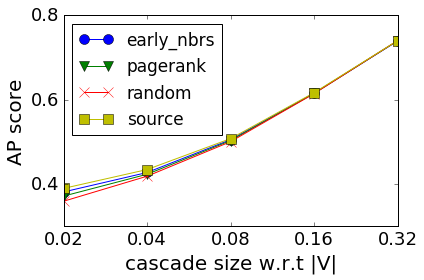

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111)
rows = np.array([df.mean().as_matrix() for df in dfs]).T
for r in rows:
    ax.plot(r, markersize=10)

ax.set_xlabel('cascade size w.r.t |V|')
ax.set_ylabel('AP score')
ax.legend(list(dfs[0].columns), loc='best', fontsize=17)
ax.set_xticklabels(infection_fractions)

for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)

ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.locator_params(axis='y', nbins=4)
ax.locator_params(axis='x', nbins=len(infection_fractions))
fig.tight_layout()

fig.savefig('figs/root-effects/{}.pdf'.format(graph_name))

In [ ]:
for f, df in zip(infection_fractions, dfs):
    print('cascade size: {}x|V|'.format(f))
    print()
    print(df.mean().sort_values(ascending=False))
    print('--'*10)
    